# KDE

(not to be confused with the Linux desktop environment [KDE](https://kde.org))

### Christian Holm Christensen

## Setup 

Some setup kode 

In [1]:
%matplotlib inline
import numpy as np
import sympy as sy
import scipy as sp
import scipy.stats 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
rcParams['figure.figsize'] = [8.,8.]
rcParams['image.cmap'] = 'cividis'
rcParams['font.serif'] = ['Palatino'] + rcParams['font.serif']
rcParams['font.family'] = ['serif']
rcParams['mathtext.fontset'] = 'dejavuserif'
rcParams['axes.formatter.use_mathtext'] = True
sy.init_printing()
np.random.seed(123)

## A function for generic KDE 

Since we will repeatedly generate KDEs and for different kernels, we set up a relatively general function to generate a KDE.   Note, we must take care with 1D arrays, since `scipy.linalg.norm` doesn't work they way we want it to work.  This code works in multiple dimensions too. 

In [2]:
def kde(data,kernel,bandwidth,**kwargs):
    
    class _k:
        def __init__(self,data,kernel,bandwidth,**kwargs):
            from numpy import asarray,newaxis
            
            self.d = asarray(data)[:,newaxis] 
            self.k = kernel
            self.h = bandwidth
            self.o = kwargs
            self.n = self._n1 if self.d.ndim == 2 else self._nd
            
        def _n1(self,x):
            from numpy import abs 
            return abs(x)
        
        def _nd(self,x):
            from numpy.linalg import norm 
            return norm(x,axis=self.d.ndim-1)
        
        def p(self,x):
            from numpy import add
            
            u = self.n(x-self.d)
            f = self.k(u,self.h,**self.o)
            r = 1/len(self.d) * add.reduce(f,axis=0)
            return r[0] if r.shape == (1,) else r
        
    return _k(data,kernel,bandwidth)

Next, we define some example kernels.  Each kernel is a function which takes as arguments 

- `u` point (or points) absolute Euclidean distance to all knots
- `h` bandwidth parameter 

This works in all dimensions since `u` will always be a real number (not a vector or tensor).  

We define 3 kernels. 

In [3]:
def parzen_rosenblatt(u,h):
    from numpy import  where
    return where(u<=h,1/(2*h),0)

In [4]:
def gaussian(u,h):
    from numpy import pi, sqrt, exp
    from numpy.linalg import norm 
    
    return 1/(sqrt(2*pi)*h)*exp(-1/2*u**2/h**2)

In [5]:
def epanechnikov(u,h):
    from numpy import where
    return where(u <= h,3/4*(1-u**2/h**2),0)/h

Next, we run some tests on these to see if it all makes sense

In [6]:
data = [1,2,5,6,12,15,16,16,22,22,22,23]

pr = kde(data,parzen_rosenblatt,1.5)
gu = kde(data,gaussian,         3)
ep = kde(data,epanechnikov,     4)

vals = [6,10.1,20.499,20.501]
comp = [(k.k.__name__,k.p(vals)) for k in (pr,gu,ep)]

print('{:20s} '.format('P(X) / X:'),end='')
for v in vals:
    print(f' {v:6.3f}',end='')
print('')
    
for n,ps in comp:
    print(f'{n:20s}:',end='')
    for pp in ps:
        print(f' {pp:6.4f}',end='')
    print('')

P(X) / X:              6.000 10.100 20.499 20.501
parzen_rosenblatt   : 0.0556 0.0000 0.0000 0.0833
gaussian            : 0.0306 0.0226 0.0466 0.0466
epanechnikov        : 0.0303 0.0121 0.0498 0.0498


Let us evaluate the probability over a larger range, finely segmented so we may map out the PDFs. 

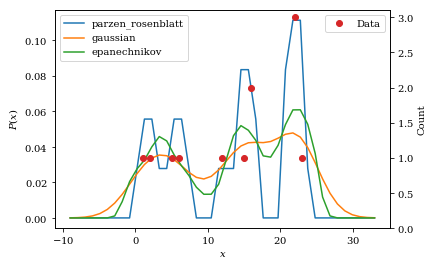

In [7]:
l = np.min(data)-10
h = np.max(data)+10
x = np.linspace(l,h,(h-l))
for k in (pr,gu,ep):
    plt.plot(x,k.p(x),label=k.k.__name__)

plt.xlabel('$x$')
plt.ylabel('$P(x)$')
plt.legend()

ax = plt.gca().twinx()
ax.plot(*np.unique(data,return_counts=True),'o',
        color='C3',label='Data')
ax.legend()
ax.set_ylim(0)
ax.set_ylabel('Count');

## KDE for $q\bar{q}$ scattering. 

We take our PDF and inverse CDF from earlier 

In [20]:
def pdf(x,alpha,beta):
    return (alpha*x + beta*x**2 + 1)/(0.571583333333333*beta + 1.9)

In [21]:
def invcdf(y,alpha,beta):
    from numpy import sqrt
    #arg1 = beta**2*(14.175*alpha*y 
    #                - 131.22*alpha 
    #                - 145.0575*beta*y 
    #                + 78.732*beta 
    #                - 567.0*y 
    #                + 291.6)
    #arg0 = (27*alpha**3 - 162*alpha*beta + arg1)
    #arg2 = sqrt(-729*(alpha**2 - 4*beta)**3 + arg0**2)*abs(beta)
    #arg3 = (27*alpha**3*beta - 162*alpha*beta**2 + beta*arg1 + arg2)
    #return (1/6)*(- 3*alpha*beta*arg3**(1/3)*abs(beta)**(2/3) 
    #              + 9*beta**2*(-alpha**2 + 4*beta) 
    #              - arg3**(2/3)*abs(beta)**(4/3))\
    #    /(beta**2*arg3**(1/3)*abs(beta)**(2/3))
    return (1/6)*(-3*alpha*beta*(27*alpha**3*beta - 162*alpha*beta**2 + beta**3*(-146.205*alpha - 185.193*beta*y + 92.5965*beta - 615.6*y + 307.8) + sqrt(-729*(alpha**2 - 4*beta)**3 + (27*alpha**3 - 162*alpha*beta + beta**2*(-146.205*alpha - 185.193*beta*y + 92.5965*beta - 615.6*y + 307.8))**2)*abs(beta))**(1/3)*abs(beta)**(2/3) + 9*beta**2*(-alpha**2 + 4*beta) - (27*alpha**3*beta - 162*alpha*beta**2 + beta**3*(-146.205*alpha - 185.193*beta*y + 92.5965*beta - 615.6*y + 307.8) + sqrt(-729*(alpha**2 - 4*beta)**3 + (27*alpha**3 - 162*alpha*beta + beta**2*(-146.205*alpha - 185.193*beta*y + 92.5965*beta - 615.6*y + 307.8))**2)*abs(beta))**(2/3)*abs(beta)**(4/3))/(beta**2*(27*alpha**3*beta - 162*alpha*beta**2 + beta**3*(-146.205*alpha - 185.193*beta*y + 92.5965*beta - 615.6*y + 307.8) + sqrt(-729*(alpha**2 - 4*beta)**3 + (27*alpha**3 - 162*alpha*beta + beta**2*(-146.205*alpha - 185.193*beta*y + 92.5965*beta - 615.6*y + 307.8))**2)*abs(beta))**(1/3)*abs(beta)**(2/3))

We check that the inverse CDF seem reasonable. 

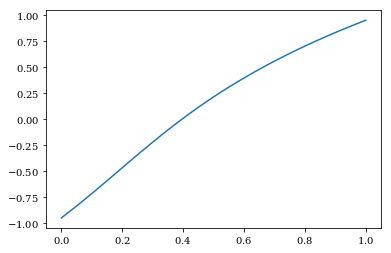

In [10]:
y = np.linspace(0,1,100)
plt.plot(y,invcdf(y,.5,.5))

We also copy over 2 functions - one to generate histograms and one to do MLE fitting to some data. 

In [11]:
def histogram(data,bins='auto'):
    from numpy import histogram as hist 
    from numpy import diff, sqrt
    from matplotlib.pyplot import errorbar, gca
    
    class _h: 
        def __init__(self,data,bins):
            self.y, self.b = hist(data,bins,density=True)
            self.x = (self.b[1:]+self.b[:-1])/2
            self.w = diff(self.b)
            self.e = sqrt(self.y/len(data)/self.w)
        def plot(self,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            return ax.errorbar(self.x,self.y,self.e,self.w/2,*args,**kwargs)
    
    return _h(data,bins)

In [12]:
def mlefit(f,data,*args,**kwargs):
    from numpy import log, sqrt, errstate
    from scipy.optimize import minimize 
    from matplotlib.pyplot import plot, gca
    
    class _mlef:
        def __init__(self,f,data,*args,**kwargs):
            self.f    = f
            opt       = minimize(lambda args: self.llh(args,data),
                                 *args,**kwargs)
            self.p    = opt.x
            self.cov  = opt.hess_inv
            self.e    = sqrt(self.cov.diagonal())
            self.nllh = -opt.fun
            
        def plot(self,x,*args,**kwargs):
            ax = kwargs.pop('ax',gca())
            return ax.plot(x,self.f(x,*self.p),*args,**kwargs)
        
        def llh(self,args,data=data):
            with errstate(invalid='ignore'):
                return -log(f(data,*args)).sum(axis=0)
            
        def __str__(self):
            txt = f'Maximum log-likelihood: {-self.nllh:.3f}\n'
            txt += 'Parameters, uncertainties, covariance:\n'
            txt += '\n'.join([f' p{i}: {p:.2f} +/- {e:.2f}\t' 
                              + '\t'.join([f'{c:.2f}' for c in self.cov[i]])
                              for i,(p,e) in enumerate(zip(self.p,self.e))])
            return txt
        
    return _mlef(f,data,*args,**kwargs)

Let us create some data. 

In [13]:
talpha = .5
tbeta = .5
data = invcdf(np.random.uniform(size=2000),talpha,tbeta)

We draw a histogram of the data together with the PDF. 

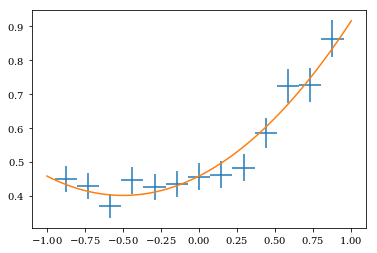

In [22]:
hist = histogram(data)
hist.plot(fmt='none',label='Data')
x = np.linspace(-1,1,100)
plt.plot(x,pdf(x,talpha,tbeta),'-',label='PDF')

Having generated our data, we can now map out the likelihood map.  This is like what we did before, just with some stuff removed. 

Maximum log-likelihood: 1214.732
Parameters, uncertainties, covariance:
 p0: 0.50 +/- 0.05	0.00	0.00
 p1: 0.61 +/- 0.11	0.00	0.01


Text(0, 0.5, '$\\beta$')

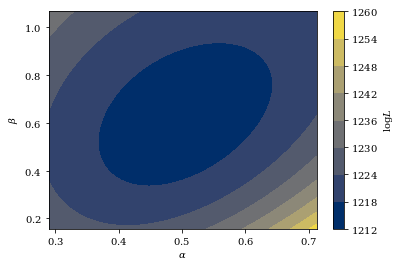

In [15]:
ne      = 4
mle     = mlefit(pdf,data,(0.5,0.5))
print(mle)
rngs    = [np.linspace(pp-ne*ee,pp+ne*ee,100) 
           for pp, ee in zip(mle.p,mle.e)]
malpha, mbeta = np.meshgrid(*rngs)
data3   = data[:,np.newaxis,np.newaxis]
malpha3 = malpha[np.newaxis,:,:]
mbeta3  = mbeta[np.newaxis,:,:]
gllh    = mle.llh((malpha3,mbeta3),data3)
mllh    = -mle.nllh
#bg      = plt.pcolor(malpha,mbeta,gllh)
bg      = plt.contourf(malpha,mbeta,gllh)
plt.colorbar(bg,label=r'$\log L$')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$\beta$')

We want to run $M$ "experiments" each with $N$ samples from our known PDF.  We copy the solution from earlier, 

In [23]:
def simvar(pdf,invcdf,par,ntrial,nsamp):
    from numpy.random import uniform
    from numpy import array, zeros_like,atleast_1d
    
    z0 = zeros_like(par)
    p0 = atleast_1d(par)
    ps = array([mlefit(pdf,invcdf(uniform(0,1,size=nsamp),*p0),z0).p for _ in range(ntrial)])
    return ps

We generate the observed $\alpha,\beta$, and define some KDEs

In [17]:
ps = simvar(pdf,invcdf,mle.p,500,2000)
pr = kde(ps,parzen_rosenblatt,.08)
gu = kde(ps,gaussian,         .08)
ep = kde(ps,epanechnikov,     .08)

Let us know plot the surfaces of the KDEs with our true distribution. 

parzen_rosenblatt (100, 100)


/usr/lib/python3/dist-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


gaussian (100, 100)
epanechnikov (100, 100)


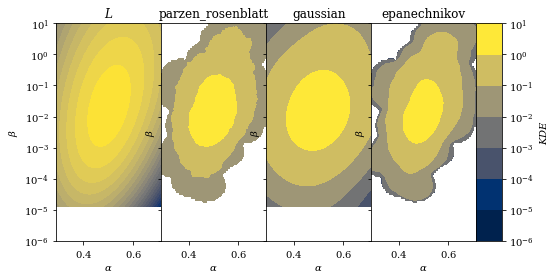

In [24]:
import matplotlib.colors as cls

fig, ax = plt.subplots(ncols=5,sharey=True,
                       figsize=(8,4),
                       gridspec_kw=dict(wspace=0,
                                        width_ratios=(4,4,4,4,1)))
ax[0].contourf(malpha,mbeta,-gllh,20)
ax[0].set_xlabel(r'$\alpha$')
ax[0].set_ylabel(r'$\beta$')
ax[0].set_title('$L$')
for k,a in zip([pr,gu,ep],ax[1:4]):
    ma = np.array([[k.p([alpha,beta]) for alpha in rngs[0]] for beta in rngs[1]])
    print(k.k.__name__,ma.shape)
    sc = a.contourf(malpha,mbeta,ma,norm=cls.LogNorm(vmin=1e-5,vmax=3))
    a.set_xlabel(r'$\alpha$')
    a.set_ylabel(r'$\beta$')
    a.set_yscale('linear')
    a.set_title(k.k.__name__)

plt.colorbar(sc,ax=ax[3],cax=ax[4],label=r'$KDE$')
    

Our KDEs are doing OK near the central value, but quickly looses breath.  Both the Parzen-Rosenblatt and Epanechinokov go to 0, and thus cannot evaluate the PDF through out the domain.  The Gaussian kernel is too coarse, but both Epanechinokov and Parzen-Rosenblatt deserves a lot of credit.  